<a href="https://colab.research.google.com/github/Nanangk/audio_classification_with_tensoflow/blob/main/Audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [2]:
#Install package
!pip install  -q pydub

In [3]:
#import some library
import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import Audio
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
#load dataset
dataset = tfds.load("gtzan_music_speech")

Shuffling and writing examples to /root/tensorflow_datasets/gtzan_music_speech/1.0.0.incomplete8TT0CE/gtzan_music_speech-train.tfrecord


Dataset gtzan_music_speech downloaded and prepared to /root/tensorflow_datasets/gtzan_music_speech/1.0.0. Subsequent calls will reuse this data.


# Explore The Dataset

In [6]:
train = dataset["train"]
data_iter = iter(train)

In [7]:
example = next(data_iter)
example

{'audio': <tf.Tensor: shape=(661500,), dtype=int64, numpy=array([-2821, -3743, -4288, ...,  -717,   132,  1548])>,
 'audio/filename': <tf.Tensor: shape=(), dtype=string, numpy=b'vlobos.wav'>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}

In [8]:
#lets hear the example of audio
audio = example.get('audio')
label = example.get('label')

print(label)
Audio(audio, rate=22050)

tf.Tensor(0, shape=(), dtype=int64)


In [9]:
index_to_class = {0 : 'music', 1 : 'speech'}
class_to_index = {'music' : 0, 'speech' : 1}

In [11]:
def plot_waveform(audio):
    plt.plot(audio)
    plt.xlabel("sample")
    plt.ylabel("amplitude")
    plt.show

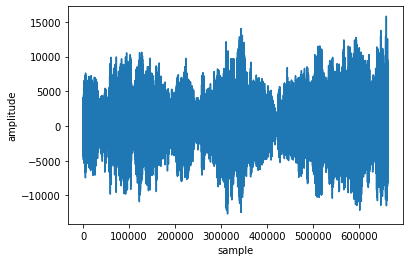

In [12]:
plot_waveform(audio)

#Spectrogram

In [13]:
def get_stft(audio, frame_length=2048, frame_step=512, fft_length=256):
  return tf.signal.stft(
      tf.cast(audio, tf.float32),
      frame_length = frame_length,
      frame_step = frame_step,
      fft_length = fft_length
  )

In [17]:
audio_stft = get_stft(audio)
audio_spec = tf.abs(audio_stft)

In [16]:
def plot_spec(spec):
  plt.figure(figsize=(12,4))
  plt.imshow(tf.transpose(spec), cmap='viridis')
  plt.colorbar()
  plt.show()

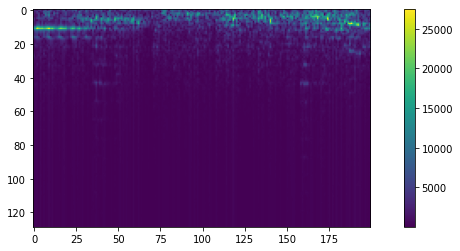

In [20]:
plot_spec(audio_spec[:200])

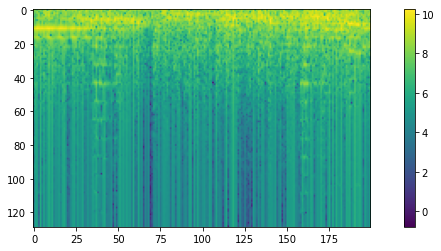

In [22]:
audio_spec_log = tf.math.log(audio_spec)
plot_spec(audio_spec_log[:200])

In [23]:
def get_spectogram(audio):
  audio_stft = get_stft(audio)
  audio_spec = tf.abs(audio_stft)
  return tf.math.log(tf.transpose(audio_spec))

#Prepare the Data

In [25]:
sr = 22050 # saple per second
chunk_len = 5 #seconds

In [29]:
def preprocess_example(example):
  audio = example.get('audio')
  label = example.get('label')

  x_batch, y_batch = None, None

  for i in range(0,6):
    start_sample = i * chunk_len * sr
    end_sample = (i+1) * chunk_len * sr
    audio_chunk = audio[start_sample:end_sample]
    audio_spec = get_spectogram(audio_chunk)
    audio_spec = tf.expand_dims(audio_spec, axis=0)
    current_label = tf.expand_dims(label, axis=0)

    x_batch = audio_spec if x_batch is None else tf.concat([x_batch, audio_spec], axis=0)
    y_batch = current_label if y_batch is None else tf.concat([y_batch, current_label], axis=0)

  return x_batch, y_batch

    

In [31]:
x_train, y_train = None, None

for example in tqdm(iter(train)):
  x_batch, y_batch = preprocess_example(example)

  x_train = x_batch if x_train is None else tf.concat([x_batch, x_train], axis=0)
  y_train = y_batch if y_train is None else tf.concat([y_batch, y_train], axis=0)


128it [00:12, 10.21it/s]


In [32]:
print(x_train.shape, y_train.shape)

(768, 129, 212) (768,)


In [33]:
indices = tf.random.shuffle(list(range(0,768)))

x_train = tf.gather(x_train, indices)
y_train = tf.gather(y_train, indices)

n_val = 300

x_valid = x_train[:n_val, ...]
y_valid = y_train[:n_val, ...]

x_train = x_train[n_val:, ...]
y_train = y_train[n_val:, ...]

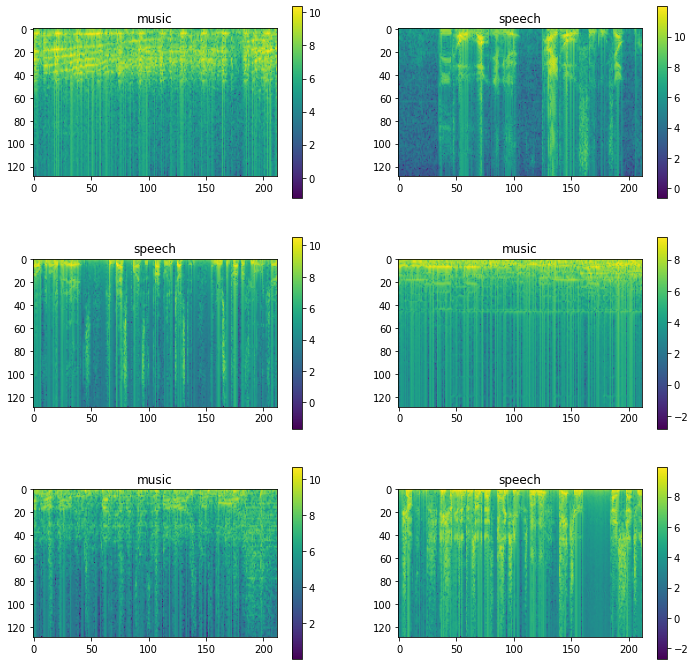

In [37]:
#lets show the dataset
plt.figure(figsize=(12,12))
st=0

for i in range(0,6):
  x,y = x_train[st+i], y_train[st+i]

  plt.subplot(3,2,i+1)
  plt.imshow(x, cmap='viridis')
  plt.title(index_to_class[y.numpy()])
  plt.colorbar()

plt.show()

#Create the Model

In [38]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization, Activation, MaxPool2D, Flatten, Dropout, Dense

In [42]:
input = Input(shape=(129, 212))
x = Lambda(lambda x : tf.expand_dims(x, axis=-1)) (input)

#convolution layer
for i in range(0,4):
  num_filters = 2**(5+i)

  x = Conv2D(num_filters,3)(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = MaxPool2D(2)(x)

#dense layer
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

#create model
model = tf.keras.Model(input, x)

In [44]:
#compile model
model.compile(
    loss='binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-6),
    metrics = ['accuracy']
)

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 129, 212)]        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 129, 212, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 210, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 210, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 127, 210, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 105, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 103, 64)       18496 